## Goal: estimate satisfaction function of a formula from instances of its satisfaction on individual runs at discrete parameter values  

Find statistical estimate of satisfaction probability $\varphi$ as function of uncertain parameters $\theta$, i.e. of the satisfaction function $f_{\varphi}(\theta) = P(\varphi | M_{\theta})$.  

Given: sample trajectories on a few input points, where we can observe the satisfaction $f_{\varphi}$.  

We want to compute an estimate of $f_{\varphi}(\theta *)$ together with a confidence interval for all possible values of $\theta$.  

Bayesian approach: define *Prior* over suitable function space $\rightarrow$ determine functional form of *likelihood* (probabilistic model of how the actual observations depend on the value of the uncertain quantity) $\rightarrow$ approximate *posterior* distribution over functions to get the estimate  
Here: use **Gaussian Processes** (flexible, non-parametric class of distributions; uncertainty quantification).  


Use **Gaussian Process Classification** to estimate the satisfaction function, because we have true/false labels per input point (= classification). Prior can be combined with likelihood models for the observations in a Bayesian fashion to yield a joint posterior.  


In [2]:
import os

import numpy as np
import numpy.matlib

import math

from scipy.stats import norm
from scipy.special import erf 
# scipy gives upper triangular matrix, numpy lower
from scipy.linalg import cholesky

import matplotlib.pyplot as plt
%matplotlib inline



# Kernel  

Use GP as prior over smooth functions. A sample of a GP is a random function.  

Popular kernel: **squared exponential** (or radial basis): $k(x,x')= \sigma^2 exp(- \frac{(x-x')^2}{2\lambda^2}) $   

We set a zero-mean Gaussian prior for f: $p(f|X) = \mathcal{N}(f|0,K)$  

___  


<!--(We place a GP prior over the latent function $f(x)$ and then squash it to obtain the prior on $\pi(x) = p(y=1|x) = \phi(f(x))$.  
Squash it with: *probit* transformation (cdf of normal distribution, $\Phi(z) = \int^z_{-\inf} \mathcal{N}(x|0,1)dx$).) -->




In [3]:
def kernel_rbf(x, y, param):
    """ Radial Basis Function Kernel 
    
    Args:
        x: First input vector of kernel (N,1)
        y: Second input vector of kernel (N,1)
        param: Hyperparameter of kernel: scale factor variance and lengthscale ell
        
    Returns:
        Covariance matrix of each pairwise combination of set of points
    """
    variance = param['var']
    lengthscale = param['ell']
    # Euclidean distance between points
    eucdist = np.sum(x**2,1).reshape(-1,1) + np.sum(y**2,1) - 2*np.dot(x, y.T)
    return variance * np.exp(-0.5 * eucdist * 1/(lengthscale**2))


def kernel_linear(x, y, param):
    """ Linear Kernel
    
    Args:
        x: First input vector of kernel (N,1)
        y: Second input vector of kernel (N,1)
        param: Hyperparameter of kernel: scale factor variance, variance_b and offset off
        
    Returns: 
        Covariance matrix of each pairwise combination of set of points
    """
    variance = param['var']
    variance_b = param['var_b']
    offset = param['off']
    return variance_b + variance * np.dot((x-offset), (y-offset).T)



# define default hyperparameters for all kernels
params = {'var': 0.1,
          'ell': 1,        
          'var_b': 1,
          'off': 1}


# TODO: optimize hyperparameters

**Likelihood model**  
Observations are made through *boolean* evaluations of a formula over individual trajectories at some parameter values. It is not possible to directly apply Gaussian observation noise, therefore a closed form solution cannot be found, only an approximation of the posterior. The satisfaction of a formula $\varphi$ over a trajectory generated from a specific parameter value $\theta$ is a Bernoulli random variable with success probability $f_{\varphi}(\theta)$. We can map this probability to the real numbers with the *inverse probit transformation*:  

$\psi (f) = g \Leftrightarrow \int_{-\infty}^g \mathcal{N} (0,1) ~ \forall f \in [0,1], ~ g \in \mathbb{R}$   

cdf of normal distribution, $\Phi(z) = \int^z_{-\inf} \mathcal{N}(x|0,1)dx$  


**Inference problem**: We have *D* binary evaluations of satisfaction at each of $P$ parameter values. At each parameter value, these evaluations represent individual draws from the same *Bernoulli* distribution with success probability $f_{\varphi}(\theta)$. The transform of this success probability is a smooth function over the (unknown) parameters and is assigned a GP prior. The *overall joint probability* of observations $O$ and of the satisfaction function would be:  

$p(O,f_{\varphi}(\theta)) = GP ( \psi (f_{\varphi}(\theta))) \prod^D \prod^P \text{Bernoulli} (O_{ij} | f_{\varphi}(\theta_j))$

**Posterior**  
Computing the posterior introduces an *approximation* (non-Gaussian likelihood makes integral intractable) $\rightarrow$ use **Expectation Propagation** algorithm to efficiently compute the approximate posterior.

<!-- ## Inference

2 steps:  
- compute distribution of latent variable corresponding to a test case: $p(f_*|X,y,x_*) = \int p(f_*|X,x_*,f) p(f|X,y) df$, where $p(f|X,y) = p(y|f)p(f|X)/p(y|X)$ is the posterior over the latent variables      

   
     
- use this distribution over latent $f_*$ to produce probabilistic prediction: $\overline{x}_* = p(y_*=1|X,y,x_*) = \int \sigma(f_*)p(f_*|X,y,x_*)df$   
-->


## Expectation Propagation

**EP** computes a Gaussian approximation to probabilistic models of the form $p(x|y) = p_0(x) \prod_i t_i(y_i,x_i)$ ($p_0$ is multivariate Gaussian distribution $\rightarrow$ Prior, and $t_i$ can be general univariate distribution $\rightarrow$ non-Gaussian observation likelihood)  
The likelihood terms are replaced by univariate Gaussian terms: $q(x|y) = p_0(x) \prod_i \tilde{t_i} (y_i,x_i)$

___

**Rasmussen**:  

Posterior given by Bayes rule as product of normalization term, prior and likelihood: $p(f|X,y) = \frac{1}{Z} p(f|X) \prod p(y_i|f_i)$  
Prior $p(f|X)$ is Gaussian, Likelihood factorizes over training cases  
Normalization term = marginal likelihood: $Z = p(y|X) = \int p(f|X) \prod p(y_i|f_i) df$  

Probit likelihood for binary classification: $p(y_i|f_i) = \Phi(f_iy_i)$ makes posterior intractable  
$\rightarrow$ approximate by local likelihood approximation (unnormalized Gaussian function in latent variable $f_i$): $p(y_i|f_i) \approx t_i ( f_i|\tilde{Z}_i,\tilde{\mu}_i,\tilde{\sigma}_i^2) = \tilde{Z}_i \mathcal{N}(f_i|\tilde{\mu}_i,\tilde{\sigma}_i^2)$  

Product of independent local likelihoods $t_i$: $\prod t_i(f_i| \tilde{Z}_i,\tilde{\mu}_i,\tilde{\sigma}_i^2) = \mathcal{N}(\tilde{\mu},\tilde{\Sigma}) \prod \tilde{Z}_i$, where $\tilde{\mu}$ is vector of $\tilde{\mu}_i$ and $\tilde{\Sigma}$ is diagonal with $\tilde{\Sigma}_{ii} = \tilde{\sigma}^2_i$.  

Approximate posterior $p(f|X,y)$ by: $q(f|X,y) \overset{\Delta}{=} \frac{1}{Z_{EP}} p(f|X) \prod t_i(f_i| \tilde{Z}_i,\tilde{\mu}_i,\tilde{\sigma}_i^2) = \mathcal{N}(\mu,\Sigma)$ [3.53] with $Z_{EP}=q(y|X)$ (approximation to normalizing term Z from previous eq.), $\mu=\Sigma\tilde{\Sigma}^{-1}\tilde{\mu}$ and $\Sigma=(K^{-1}+\tilde{\Sigma}^{-1})^{-1}$  

How do we choose parameter of local approximating distributions $t_i$? Minimize Kullback-Leibler divergence between posterior and its approximation. Update $t_i$ approximations sequentially. Start from current approximate posterior, leave out current $t_i$ ($\rightarrow$ cavity distribution; Combine prior and local likelihood approximations into cavity distribution: $q_{-i}(f_i) \propto \int p(f|X) \prod_{j\neq i} t_j (f_j|\tilde{Z}_j, \tilde{\mu}_j, \tilde{\sigma}_j^2) df_j$, either by explicitly multiplying out the terms, or by removing approximate likelihood i from the approximate posterior in 3.53). Combine cavity with exact likelihood to get desired (non-Gaussian) marginal. Choose Gaussian approximation to this non-Gaussian marginal and then compute the $t_i$ which makes posterior have the desired marginal. Iterate these steps until convergence.


<!-- ### 2) Perform smoothed model checking (SMC 65)

getAnalyticApproximation(data, parameters, options)  
-> optimize hyperparameters for rbf kernel or take default ones  
-> doTraining = probit gp regression  
   -> expectationPropagation
   
then return performSmoothedModelChecking(approx, parameters, options) -->

### Helper functions for EP  

**Marginal moments** $\mu$ and $\sigma^2$  



**Rasmussen 3.53:**. 

$q(f|X,y) \overset{\Delta}{=} \frac{1}{Z_{EP}} p(f|X) \prod t_i(f_i| \tilde{Z}_i,\tilde{\mu}_i,\tilde{\sigma}_i^2) = \mathcal{N}(\mu,\Sigma)$   

with $Z_{EP}=q(y|X)$,   

$\mu=\Sigma\tilde{\Sigma}^{-1}\tilde{\mu}$, $\tilde{\Sigma}$ is diagonal with $\tilde{\Sigma}_{ii} = \tilde{\sigma}_i^2$   

$\Sigma=(K^{-1}+\tilde{\Sigma}^{-1})^{-1}$   



**Here:**  


! Attention: computation of cholesky(A) may fail when A is not PD (for large amplitudes) --> add another +I for computational stability?    




(Note: Cholesky returns $L'$ for $A = L * L' $)    

$L = (cholesky({LC}' * (\tilde{\tau} * {LC}) + I))'$  

$L * W = LC' \rightarrow$ Solve for $W$: $W = L^{-1} * LC'$   

$diagV = diag(W' * W)$  

$m = W' * (W * \tilde{v})$  

$logdet = -2 * \sum \log(diag(L)) + 2 * \sum \log(diag(LC))$  

$logZappx = \frac{1}{2} (m' * \tilde{v} + logdet)$



Note:   
$\tilde{v} = \tilde{\mu} \tilde{\sigma}^{-2} = \tilde{\mu} * \tilde{\tau} $  
$\tilde{\tau} = \tilde{\sigma}^{-2}$  


In [55]:
def marginal_moments(Term, gauss_LC, gauss_LC_t):
    """
    Computes marginal moments
    
    Args:
        Term: v_tilde, tau_tilde (datapoints, 2)
        gauss_LC:
        gauss_LC_t: 
        
    Returns:
        logZappx: 
        gauss_m: mu (datapoints,1)
        gauss_diagV: diagonal of sigma^2 (datapoints,1)
    """
    
    # A = LC' * (tau_tilde * gauss_LC) + I 
    #print("t:", Term[:,1])
    tmp = np.multiply(Term[:,1], gauss_LC)
    A = np.matmul(gauss_LC_t, tmp) + 1 * np.eye(datapoints)
    #print("A:", A)
    #print("Eig:", np.linalg.eigvalsh(A))
    gauss_L = cholesky(A).T  

    # W = L\LC' -> Solve L*W = LC'
    gauss_W = np.linalg.solve(gauss_L, gauss_LC_t)
    gauss_diagV = np.diagonal(np.matmul(gauss_W.T, gauss_W)).reshape(-1,1)
    
    # m = W'*(W * v_tilde)
    tmp = np.matmul(gauss_W, Term[:,0])
    gauss_m = np.matmul(gauss_W.T, tmp).reshape(-1,1)

    # logdet = -2*sum(log(diag(L))) + 2*sum(log(diag(LC)))
    logdet = -2*np.sum(np.log(np.diagonal(gauss_L))) # + 2*np.sum(np.log(np.diag(gauss_LC))) (das ist schon logdet_LC)
    logdet += logdet_LC

    # logZappx = 1/2(m' * v_tilde + logdet)
    logZappx = 0.5 * (np.dot(gauss_m.T, Term[:,0]) + logdet)

    return logZappx, gauss_m, gauss_diagV

https://en.wikipedia.org/wiki/Gauss–Hermite_quadrature  

**Gauss-Hermite quadrature** is a form of Gaussian quadrature for approximating the value of integrals of the following kind:  

$ \int_{-\infty}^{+\infty} e^{-x^2} f(x) dx \approx \sum_{i=1}^n w_i f(x_i)  $  

where $n$ is the number of sample points used (here: nodes). The $x_i$ are the roots of the physicists' version of the Hermite polynomial $H_n(x)$ and the associated weights $w_i$ are given by:  

$ w_i = \frac{ 2^{n-1} n! \sqrt{\pi}}{n^2 [H_{n-1}(x_i)]^2}$   


Binary classification: determining moments of tilted distribution requires solving only 1-dimensional integrals; assuming probit likelihood functions $\rightarrow$ univariate integrals can be computed efficiently without quadrature. But here: need quadrature because we have multiple observations per input point


In [5]:
def gausshermite(nodes):
    """
    Gauss-Hermite 
    https://indico.frib.msu.edu/event/15/attachments/40/157/Gaussian_Quadrature_Numerical_Recipes.pdf
    
    Approximate integral of a formula by the sum of its functional values at some points
    
    Args:
        nodes: number of Gauss-Hermite nodes (96,1)
        
    Returns:
        x0: abscissas (96,1)
        w0: weights (96,1)
    """

    x0 = np.zeros((nodes, 1))
    w0 = np.zeros((nodes, 1))
    m = int((nodes+1)/2)
    z,pp,p1,p2,p3 = 0,0,0,0,0
    
    for i in range(m):
        if i==0:
            z = np.sqrt(2*nodes+1) - 1.85575 * ((2*nodes+1)**(-0.166667))
        elif i==1:
            z = z - 1.14 * (nodes**0.426) / z
        elif i==2:
            z = 1.86 * z - 0.86 * x0[0]
        elif i==3:
            z = 1.91 * z - 0.91 * x0[1]
        else:
            z = 2.0 * z - x0[i - 2]

        for its in range(10):
            p1 = 1/np.sqrt(np.sqrt(np.pi))
            p2 = 0
            for j in range(1,nodes+1):
                p3=p2
                p2=p1
                a = z*np.sqrt(2/j)*p2
                b = np.sqrt((j-1)/j)*p3
                p1=a-b
            pp=np.sqrt(2*nodes)*p2
            z1=z
            z=z1-p1/pp
            if np.abs(z-z1)<2.2204e-16:
                break

        x0[i] = z
        x0[nodes-1-i] = -z
        w0[i] = 2/(pp*pp)
        w0[nodes-1-i] = w0[i]

    w0 = np.divide(w0, np.sqrt(np.pi))
    x0 = np.multiply(x0, np.sqrt(2))
    x0 = np.sort(x0, axis=None).reshape(-1,1)
    
    return x0, w0




Compute **new posterior marginal moments** $\hat{\mu}$ and $\hat{\sigma}^2$   

Find new Gaussian marginal which best approximates the product of the cavity distribution and the exact likelihood $\hat{q}(f_i) \overset{\Delta}{=} \hat{Z}_i ~ \mathcal{N}(\hat{\mu}_i, \hat{\sigma}^2_i) \simeq q_{-i} (f_i) p (y_i | f_i) $.  

It is well known that distribution $q(x)$ which minimizes KL$(p(x)||q(x))$ is the one whose first and second moments match that of $p(x)$. <!--$\hat{q}(f_i)$ is unnormalized, so choose additionally the condition that zero-th moments (normalizing constants) should match when choosing the parameters of $\hat{q}(f_i)$ to match the right-hand side of above equation.-->  
Derivation of moments is complicated (see Appendix 3.9). Desired posterior marginal moments are:  

**Rasmussen 3.58:**  

$ \hat{Z} = \Phi (z)$  

$ \hat{\mu} = \mu_{-i} + \frac{y ~ \sigma^2_{-i} \mathcal{N}(z)} { \Phi(z) \sqrt{1 + \sigma^2_{-i}}} $  

$ \hat{\sigma}^2 = \sigma^2_{-i} - \frac{ \sigma^4_{-i} \mathcal{N}(z)} {(1 + \sigma^2_{-i}) \Phi (z) } (z + \frac{\mathcal{N}(z)} {\Phi (z)} ) $,  


where $z = \frac{y ~ \mu_{-i}} { \sqrt{1 + \sigma^2_{-i}} } $  


Here:  

$G = \text{logprobitpow}((\sigma_{-i} * xGH + \mu_{-i}), p, q) + logwGH'$, $G = G - \max(G)$ for each datapoint   

**Gauss-Hermite** to match distribution https://www.wouterdenhaan.com/numerical/integrationslides.pdf 
Get $n$ nodes ($xGH$) and weights ($logwGH$) from function *gausshermite*. Expectation of normally distributed variable: $E[h(y)]$ with $y \sim \mathcal{N}(\mu,\sigma^2)$.  
Calculate $\int_{-\infty}^{\infty} \frac{1}{\sigma \sqrt{2 \pi}} h(y) \exp(- \frac{(y-\mu)^2}{2\sigma^2})dy$  
$\rightarrow$ do a trick with change of variables and transformation, then approximation is:  

$E[h(y)] \approx \sum_{i=1}^n \frac{1}{\sqrt{\pi}} w_i h(\sqrt{2} \sigma x_i + \mu)$

$\rightarrow$ this relates to $ \text{logprobitpow}((\sigma_{-i} * xGH + \mu_{-i}), p, q) + logwGH'$, because nodes $x_i$ are already multiplied by $\sqrt{2}$ and weights $w_i$ are already divided by $\sqrt{\pi}$ in *gausshermite*. Since we're taking the logarithm, we have $\log x \cdot y = \log x + \log y$, so $+ logwGH$ in $G$ instead of $\cdot w_i$.   

But: Why do we take maximum then instead of summing the values?  


$logZ = maxG + \log(\sum e^G)$ (sum over rows, for each datapoint)  

Moments:  

$\hat{\mu} = \mu_{-i} + \Delta_m \rightarrow \Delta_m = \frac{\sigma_{-i} * (e^G * xGH)}{\sum e^G} $  

$\hat{\sigma}^2 = \frac{\sigma_{-i}^2 * (e^G * xGH^2)}{\sum e^G} - \Delta_m^2$  

$logZ = \max(G) + \log(\sum \exp(G - \max(G))) = \log \sum \exp(G)$ is smooth approximation to get largest element of $G$. 

In [6]:
def GaussHermiteNQ(FuncPar_p, FuncPar_q, cav_m, cav_v, xGH, logwGH):
    """
    Gauss-Hermite numerical quadrature for moment computation
    
    Args:
        FuncPar_p: number of runs satisfying property for each parameter value (input) (datapoints,1)
        FuncPar_q: number of runs not satisfying property (datapoints,1)
        cav_m: cavity mean mu_-i
        cav_v: cavity variance sigma^2_-i
        xGH: abscissas (Gauss-Hermite)
        logwGH: weights (Gauss-Hermite)
        
    Returns:
        logZ: largest element of expectation of normally distributed variable?
        Cumul: mu_hat, sigma^2_hat (datapoints,2)
    """
    
    Nnodes = len(xGH)
    
    # sigma_-i
    stdv = np.sqrt(cav_v).reshape(-1,1)

    # HIER PROBLEM: Dadurch dass stdv von cavity gerechnet wird & cavity variance auch negativ sein kann,
    # ist stdv nicht für alle Werte definiert -> dadurch cholesky in marginal_moments = 2I
    Y = np.matmul(stdv, xGH.reshape(1,-1)) + numpy.matlib.repmat(cav_m, 1, Nnodes)
        
    G = np.array(logprobitpow(Y, FuncPar_p, FuncPar_q) + numpy.matlib.repmat(logwGH.T, datapoints, 1))
        
    # maximum of each row (input value) over all 96 nodes
    maxG = G.max(axis=1).reshape(-1,1)
    # subtract maximum value
    G = G - np.matlib.repmat(maxG, 1, 96)
    # exponential value
    expG = np.exp(G)
    # denominator (row sum)
    denominator = expG.sum(axis=1).reshape(-1,1)
    logdenominator = np.log(denominator)
    logZ = maxG + logdenominator
    
    Cumul = np.zeros((len(FuncPar_p), 2))


    # deltam = stdv * (expG * xGH) / denominator
    deltam = np.divide(np.multiply(stdv, np.matmul(expG, xGH)), denominator)

    # mu_hat = mu_-i + deltam    
    Cumul[:,0] = (cav_m + deltam).reshape(-1)
    
    xGH2 = xGH**2
    deltam2 = deltam**2

    # sigma^2_hat
    Cumul[:,1] = (np.divide(np.multiply(cav_v, np.matmul(expG, xGH2)), denominator) - deltam2).reshape(-1)
        
    return logZ, Cumul

Compute **cavity parameters** $\mu_{-i}$ and $\sigma^2_{-i}$   

**Rasmussen 3.56:**   


$cav_m = \mu_{-i} = \sigma_{-i}^2 \cdot ( \frac{\mu}{\sigma^2} - \frac{\tilde{\mu}}{\tilde{\sigma}^2} )$   



$cav_v =  \sigma_{-i}^2 = \frac{1}{\sigma^{-2} - \tilde{\sigma}^{-2}}  $   


**Here:** $diagV = \sigma^2$ and $\tilde{\tau} = \tilde{\sigma}^{-2}$ and $\tilde{v} = \tilde{\mu} \tilde{\sigma}^{-2}$; transforming the equations shows that they're equal:      

$cav_m = \frac{m + (- \tilde{v} \cdot diagV) }{1 + (- \tilde{\tau} \cdot diagV)} = \frac{ \mu - \tilde{\sigma}^{-2} \tilde{\mu} \sigma^2}{1 - \tilde{\sigma}^{-2} \sigma^2} $   


$cav_{diagV} = \frac{diagV}{1 + (- \tilde{\tau} * diagV)} = \frac{1}{diagV^{-1} - \tilde{\tau}} = \frac{1}{\sigma^{-2} - \tilde{\sigma}^{-2}}$   


The cavity distribution combines the prior and the local likelihood approximations; afterwards, it is combined with the exact likelihood for case $i$. To do so, we remove the approximate likelihood $i$ from the approximate posterior by dividing the marginal with the approximate term $t_i$.  
$q_{-i}(x) = \frac{q(x)}{\tilde{\tau}_i(x)}$

In [7]:
def cavities(gauss_diagV, gauss_m, Term):
    """
    Compute cavity distribution by removing the effect of a single factor from q
    
    Args:
        gauss_diagV: sigma^2
        gauss_m: mu
        Term: v_tilde, tau_tilde (datapoints,2)
        
    Returns:
        cav_m: cavity mean mu_-i
        cav_diagV: cavity variance sigma^2_-i
    """
    
    # s = 1 / (1 + -tau_tilde * diagV)
    s = np.divide(1, (1 + np.multiply(-Term[:,1].reshape(-1,1), gauss_diagV)))

    # cav_diagV = s * diagV
    cav_diagV = np.multiply(s, gauss_diagV)
    
    # cav_m = s * (m + (-v_tilde * diagV))
    cav_m = np.multiply(s, (gauss_m + np.multiply(-Term[:,0].reshape(-1,1), gauss_diagV)))
    
    return cav_m, cav_diagV
        

Update **site parameters** $\tilde{v}$ and $\tilde{\tau}$ with new posterior marginal moments $\hat{\mu}$ and $\hat{\sigma}^2$.  

Final step is to compute the parameters of the approximation $t_i$ which achieves a match with the desired moments. In particular, the product of the cavity distribution and the local approximation must have the desired moments.  


**Rasmussen 3.59**   

$\tilde{\mu}_i = \tilde{\sigma}_i^2 ( \hat{\sigma}_i^{-2} \hat{\mu}_i - \sigma_{-i}^{-2} \mu_{-i})$  

$\tilde{\sigma}_i^2 = (\hat{\sigma}_i^{-2} - \sigma_{-i}^{-2})^{-1}$  


**Here**: just simple transformation  


$\tilde{v} = \hat{\sigma}_i^{-2} \hat{\mu}_i - \sigma_{-i}^{-2} \mu_{-i} = \tilde{\sigma}_i^{-2} \tilde{\mu}_i$  

$\tilde{\tau} = 1 / \hat{\sigma}_i^2 - 1 / \sigma_{-i}^2 = \tilde{\sigma}_i^{-2}$   

$logZterms = logZ + \frac{1}{2} * (\frac{\mu_{-i}^2}{\sigma_{-i}^2} + \log(\sigma_{-i}^2) - \frac{\hat{\mu}^2}{\hat{\sigma}^2} + \log(\hat{\sigma}^2))$

In [8]:
def ep_update(cav_diagV, cav_m, Term, eps_damp, gauss_LikPar_p,
              gauss_LikPar_q, gauss_xGauss, gauss_logwGauss):
    """
    Update site parameters
    
    Args:
        cav_diagV: cavity variance sigma^2_-i
        cav_m: cavity mean mu_-i
        Term: v_tilde, tau_tilde (datapoints,2)
        eps_damp: 0.5
        gauss_LikPar_p: number of runs satisfying property for each parameter (datapoints,1)
        gauss_LikPar_q: number of runs not satisfying property (datapoints,1)
        gauss_xGauss: abscissas of Gauss-Hermite
        gauss_logwGauss: weights of Gauss-Hermite
        
    Returns:
        TermNew: updated v_tilde, tau_tilde (datapoints,2)
        logZterms:
        logZ:
    """

    
    # Cumul = [mu_hat, sigma^2_hat]    
    # Evaluate new approximation q_hat(x) by setting the sufficient statistics equal to that of probit*cavity
    logZ, Cumul = GaussHermiteNQ(gauss_LikPar_p, gauss_LikPar_q, cav_m, cav_diagV, gauss_xGauss, gauss_logwGauss)
    
    
    # m2 = mu_-i ^2
    m2 = cav_m**2
    # loV = log(sigma_-i^2)
    logV = np.log(cav_diagV)
    
    # cumul1 = mu_hat^2
    cumul1 = (Cumul[:,0]**2).reshape(-1,1)
    # cumul2 = log(sigma^2_hat)
    cumul2 = (np.log(Cumul[:,1])).reshape(-1,1)    
    
    # logZ + 1/2 * ((mu_-i^2 / sigma_-i^2) + log(sigma_-i^2) - (mu_hat^2 / sigma_hat^2) + log(sigma_hat^2))
    logZterms = logZ + np.multiply(np.divide(m2, cav_diagV) + logV - 
                                   (np.divide(cumul1, Cumul[:,1].reshape(-1,1)) + cumul2), 1/2)
        
    # c1 = mu_hat / sigma_hat^2 - mu_-i / sigma_-i^2 = v_tilde
    #c1 = np.divide(Cumul[:,0].reshape(-1,1), Cumul[:,1].reshape(-1,1)) - (np.divide(cav_m, cav_diagV))
    # c2 = 1 / sigma_hat^2 - 1 / sigma_-i^2 = tau_tilde
    #c2 = np.divide(np.ones((datapoints,1)), Cumul[:,1].reshape(-1,1)) - (np.divide(np.ones((datapoints,1)), cav_diagV))
    
        
    
    ### hier sind die ganzen if-bedingungen, um negative werte und anderes zu pruefen
    # kommt aber nie in die bedingungen rein, und hab trotzdem das problem mit negativen werten
    c1 = np.zeros((datapoints,1))
    c2 = np.zeros((datapoints,1))
    for i in np.arange(datapoints):
        if (1/cav_diagV[i] == 1/Cumul[i,1]):
            c2[i] = 1e-4
        else:
            c2[i] = (1 / Cumul[i,1]) - (1 / cav_diagV[i])

     
    for k in np.arange(datapoints):
        if((1/c2[k] == np.infty) and (1/cav_diagV[k] == 0 or gauss_m[k] == cav_m[k])):
            c1[k] = cav_m[k] * cav_diagV[k]
        else:
            c1[k] = Cumul[k,0] / Cumul[k,1] - cav_m[k] / cav_diagV[k]

    for j in np.arange(datapoints):
        if (1/c2[j] + cav_diagV[j]) < 0:
            c1[j] = Term[j,0]
            c2[j] = Term[j,1]
        else:
            continue

            
    TermNew = np.concatenate((c1, c2), axis=1)
    TermNew = np.multiply(Term, (1 - eps_damp)) + np.multiply(TermNew, eps_damp)

    
    return TermNew, logZterms, logZ

Compute log of **probit function** 

**Rasmussen Appendix 3.9**    

$\Phi(f(x)) = \frac{1}{2} (1 + erf( x / \sqrt{2} )) $  


**Here** multiplication with true observation values:  


In [9]:
def logprobitpow(X, p, q):
    """
    Compute ncdflogbc for matrices -> log of standard normal cdf by 10th order Taylor expansion in the negative domain
    log likelihood evaluations for various probit power likelihoods
    
    Args:
        X: matrix (datapoints,96)
        p: number of runs satisfying property for each parameter, repeated (datapoints,96)
        q: number of runs not satisfying property, repeated (datapoints,96)
        
    Returns:
        Za+Zb:
    """
    
    threshold = -np.sqrt(2)*5
    Za = []
    y = []
    j = 0
    for x in X:
        y.append([])
        #print(x)
        for i in x:
            if i >= 0:
                y[j].append(np.log(1 + erf(i/np.sqrt(2))) - np.log(2))
            elif ((threshold < i) and (i < 0)):
                y[j].append(np.log(1 - erf((-i)/np.sqrt(2))) - np.log(2))
            elif i <= threshold:
                y[j].append(-1/2 * np.log(np.pi) - np.log(2) - 1/2 * (-i) * (-i) - \
                np.log((-i)) + np.log(1 - 1/(-i) + 3/((-i)**4) - 15/((-i)**6) + 105/((-i)**8) - 945/((-i)**10)))
        j+=1
    #print(y)
    Za = np.multiply(y, numpy.matlib.repmat(p.reshape(-1,1), 1, 96))

    Zb = []
    y = []
    j = 0
    for x in (-X):
        y.append([])
        #print(x)
        for i in x:
            #print(i)
            if i >= 0:
                y[j].append(np.log(1 + erf(i/np.sqrt(2))) - np.log(2))
            elif ((threshold < i) and (i < 0)):
                y[j].append(np.log(1 - erf((-i)/np.sqrt(2))) - np.log(2))
            elif i <= threshold:
                y[j].append(-1/2 * np.log(np.pi) - np.log(2) - 1/2 * (-i) * (-i) - \
                np.log((-i)) + np.log(1 - 1/(-i) + 3/((-i)**4) - 15/((-i)**6) + 105/((-i)**8) - 945/((-i)**10)))
        j+=1

    Zb = np.multiply(y, numpy.matlib.repmat(q.reshape(-1,1), 1, 96))
    return Za + Zb
    

## Expectation Propagation Algorithm  

<!--Problem: the exact computation of the posterior probability is not possible: use approximation from **Expectation Propagation (EP)** approach (high accuracy + computational efficiency) 

EP computes a Gaussian approximation to probabilistic models of the form
$ p(x|y) = p_0(x) \prod_i t_i (y_i,x_i)$   

$p_0(x)$ is a multivariate Gaussian distribution coupling all $x_i$ variables (*site variables*), $t_i$ can be general univariate distributions. Those models are calles *latent Gaussian models*: p0 represents prior distribution, with ti representing non-Gaussian observation likelihoods.  
EP approximation: likelihood terms replaced by univariate Gaussian terms $ q(x|y) = p_0(x) \prod_i \tilde{t}_i (y_i,x_i) $   
-->


Initialization: Create data set of 20 input values (uncertain parameter that is varied) and the respective output values (number of trajectories satisfying the property divided by total number of trajectories $\rightarrow$ statistical estimate of satisfaction probablity)






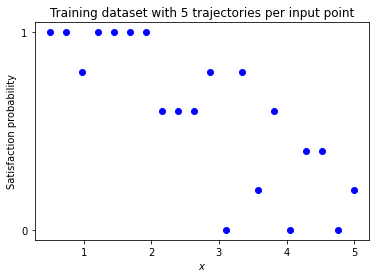

Actual data (number of runs satisfying property):  [[5. 5. 4. 5. 5. 5. 5. 3. 3. 3. 4. 0. 4. 1. 3. 0. 2. 2. 0. 1.]]


In [48]:
## configuration and data

# data from Bortolussi paper
simulation_runs = scale = 5  # number of trajectories per input point
paramValueSet = np.linspace(0.5, 5, 20).reshape(-1,1) # uncertain input parameter that is varied = population size
datapoints = len(paramValueSet)  # number of input points
paramValueOutputs = np.array([1,1,0.8,1,1,1,1,0.6,0.6,0.6,0.8,0,0.8,0.2,0.6,0,0.4,0.4,0,0.2]).reshape(-1,1) # statistical outputs of satisfaction 
data = trainingSet = [paramValueSet, paramValueOutputs] # set as training set for GP

correction = 1e-4

# define default hyperparameters for all kernels
params = {'var': 1/scale,
          'ell': 3,        
          'var_b': 1,
          'off': 1}

# plot training data
plt.scatter(paramValueSet, paramValueOutputs, marker='o', c='blue')
plt.title(f'Training dataset with {simulation_runs} trajectories per input point')
plt.xlabel('$x$')
plt.ylabel('Satisfaction probability')
plt.yticks([0, 1])
plt.show()

print("Actual data (number of runs satisfying property): ", (paramValueOutputs * scale).reshape(1,-1))

## Stochnet Histogram Bee Data  

Simulate 2-reaction model for population sizes from 15 to 150 bees and collect number of stinging bees after each simulation. Collect data from 10.000 simulations and check for following property:  

What is the probability that at least $15\%$ of the population survives? ($P(S ~ bees \geq 0.15)$?)  

Precalculations: Infer number of alive bees from txt files and percentage of surviving bees from the experiments. Then, compute how often the property is satisfied. 



In [49]:
# threshold for checking the property (how many bees survive)
#thresh = 0.20
thresh = 0.23
collect_data = {}

# read outcomes for all population sizes and compute number of satisfactions
for dirpath, dirs, files in os.walk("../data/stochnet"):
    for file in files:
        nbees = int((file.split("_")[1]).split(".")[0])
        with open(os.path.join(dirpath, file), 'r') as f:
            data = f.read()
            x_deadbees = (data.split("]")[0])[2:].replace(".","")
            y_frequencies = (data.split("]")[1])[2:]
            # compute number of living bees 
            bees = np.array([nbees-int(i) for i in x_deadbees.split()])
            freq = np.array([int(i) for i in y_frequencies.split()])
            
            threshold = np.ceil(thresh * nbees)            
            satisfactions = np.sum(freq[bees >= threshold])
            
            collect_data[nbees] = satisfactions
            
# population size n together with number of trajectories satisfying property, sort by n
paramValueSet = []
paramValueOutputs = []
for key in sorted(collect_data):
    paramValueSet.append(key)
    paramValueOutputs.append(collect_data[key])
    #print("%s: %s" % (key, collect_data[key]))


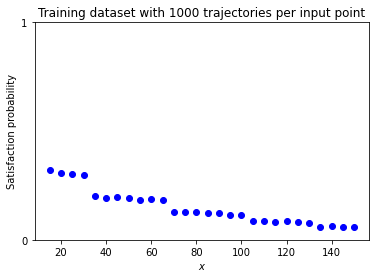

Actual data (number of runs satisfying property):  [[321.4 308.  303.1 296.1 201.5 194.1 196.5 191.1 183.5 186.4 181.  129.8
  129.4 127.  122.  123.  115.8 115.   86.4  86.   82.8  86.9  83.6  75.2
   57.8  62.3  59.   57.8]]


In [50]:
## configuration and data

simulation_runs = scale = 10000  # number of trajectories per input point
paramValueSet = np.array(paramValueSet).reshape(-1,1) # uncertain input parameter that is varied = population size
datapoints = len(paramValueSet)  # number of input points
paramValueOutputs = (np.array(paramValueOutputs).reshape(-1,1))/scale # statistical outputs of satisfaction 
data = trainingSet = [paramValueSet, paramValueOutputs] # set as training set for GP
simulation_runs = scale = 1000  # number of trajectories per input point


# set scale to 1000, then var=0.01 and ell=10 works
# set scale to 100, then var=0.13, ell=13 works

correction = 1e-4

# define default hyperparameters for all kernels
params = {'var': 0.01,
          'ell': 10,    
          'var_b': 1,
          'off': 1}

# plot training data
plt.scatter(paramValueSet, paramValueOutputs, marker='o', c='blue')
plt.title(f'Training dataset with {simulation_runs} trajectories per input point')
plt.xlabel('$x$')
plt.ylabel('Satisfaction probability')
plt.yticks([0, 1])
plt.show()

print("Actual data (number of runs satisfying property): ", (paramValueOutputs * scale).reshape(1,-1))


### How do we choose parameters of local approximating distributions $t_i$?  


**Algorithm** proceeds *iteratively*: update individual $t_i$ approximations sequentially until convergence (= all marginal distributions $q(f_i)$ are consistent with $\hat{p}(f_i)$ ):  
1. start from some current approximate posterior, from which we leave out a site index $i$ (remove approx. likelihood term corresponding to $i$, marginalise all other variables) $\rightarrow$ marginal *cavity distribution*    
2. Combine cavity distribution with exact likelihood $p(y_i|f_i)$ to get desired (non-Gaussian) marginal, or *tilted distribution*  
3. Update EP approximation by replacing the initial approximation likelihood term with the new term $\tilde{t}$ obtained by finding the Gaussian which matches the moments of the tilted distribution    
4. Apply iteratively to all sites until the moment of the EP approximation does not change   


(? Normally you iterate through all data points, but here you just take them all at once)  



In [51]:
# initialization (all 0)
# Prior
gauss_C = kernel_rbf(paramValueSet, paramValueSet, params) + correction * np.eye(datapoints) # covariance training set

gauss_LC_t = cholesky(gauss_C)  # cholesky decomposition, returns U from A=U'*U (U=L')
gauss_LC = gauss_LC_t.T  # transpose LC' 
gauss_LC_diag = np.diagonal(gauss_LC).reshape(-1,1)

logdet_LC = 2*np.sum(np.log(gauss_LC_diag))
logZprior = 0.5*logdet_LC

logZterms = np.zeros(datapoints).reshape(-1,1)
logZloo = np.zeros(datapoints).reshape(-1,1)
Term = np.zeros((datapoints, 2))  # Term = v_tilde, tau_tilde

# compute marginal moments mu and sigma^2
_, gauss_m, gauss_diagV = marginal_moments(Term, gauss_LC, gauss_LC_t)

# related to likelihood approximation
# true observation values (number of trajectories satisfying property)
gauss_LikPar_p = paramValueOutputs * scale
gauss_LikPar_q = scale - gauss_LikPar_p 

# gauss hermite: quadrature to approximate values of integral, returns abscissas (x) and weights (w) of
# n-point Gauss-Hermite quadrature formula
nodes = 96
gauss_xGauss, gauss_wGauss = gausshermite(nodes)
gauss_logwGauss = np.log(gauss_wGauss)

# configurations for loop initialization
MaxIter=1000
tol=1e-6
logZold=0
logZ = 2*tol
steps=0
logZappx=0
eps_damp=0.5

while (np.abs(logZ-logZold)>tol) and (steps<MaxIter):
    steps += 1
    logZold = logZ
    
    # find cavity distribution parameters mu_-i and sigma^2_-i
    cav_m, cav_diagV = cavities(gauss_diagV, gauss_m, Term)
    
    # update marginal moments mu_hat and sigma^2_hat, and site parameters v_tilde and tau_tilde
    Term, logZterms, logZloo = ep_update(cav_diagV, cav_m, Term, eps_damp, gauss_LikPar_p,
                      gauss_LikPar_q, gauss_xGauss, gauss_logwGauss)
    
    # recompute mu and sigma^2 from the updated parameters
    logZappx, gauss_m, gauss_diagV = marginal_moments(Term, gauss_LC, gauss_LC_t)
    
    logZ = logZterms.sum() + logZappx
    
    print("Iteration ", steps)
    
print("\nFinish")
    
    
logZ = logZ - logZprior
gauss_logZloo = logZloo.sum()
gauss_logZappx = logZappx
gauss_logZterms = logZterms
gauss_logZ = logZ
gauss_Term = Term

t: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Eig: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
t: [298.34487929 295.14388016 293.90810488 292.08105388 259.63225255
 256.41972386 257.47350924 255.08624693 251.62601707 252.96038997
 250.46162904 223.51540078 223.27968951 221.85650343 218.84177087
 219.45015631 215.00788187 214.50531032 195.273517   194.98603887
 192.66659613 195.63210505 193.2497462  187.01467191 173.26469269
 176.93415684 174.25126626 173.26469269]
Eig: [ 0.96366413  0.96996345  0.98476523  0.99101854  1.01438204  1.01630027
  1.01736037  1.01799921  1.02034814  1.02103064  1.02562176  1.03830236
  1.05519924  1.09135811  1.17435648  1.29079545  1.53319055  1.86362427
  2.35617409  3.02490511  3.89743503  5.04597329  6.37284938  7.86924306
  9.14354687 10.51223101 12.00840043 14.08037581]
Iteration  1
t: [446.40686729 440.19055487 436.60226097 432.10122019 389.98014129
 378.64093289 3

t: [594.34198144 584.79050594 578.33148448 569.4850003  524.72578559
 502.39030959 492.14404166 487.47673128 483.0037404  480.3902976
 474.08214098 437.9892549  422.29343453 410.01592629 401.36763983
 399.6245843  390.57052319 387.38304757 361.30234497 350.5790013
 338.56242497 335.36269436 329.59193088 323.92392265 305.18118226
 292.15676011 276.07001288 304.69700553]
Eig: [ 0.95657397  0.9657241   0.98156158  0.98918707  1.00210055  1.00600093
  1.00982196  1.01501056  1.02118553  1.02602772  1.03678236  1.05094292
  1.08716667  1.14856439  1.29211579  1.51011356  1.92869761  2.53858377
  3.4479044   4.72943402  6.35837084  8.48531021 10.96830075 13.58578891
 16.19785362 18.71621862 22.07698398 26.75396491]
Iteration  13
t: [594.3773973  584.82605664 578.36792538 569.51422121 524.75963687
 502.42267606 492.17513554 487.50465549 483.03231505 480.42051001
 474.1029663  438.01789876 422.31850983 410.03726274 401.38494675
 399.64240958 390.60329405 387.40054022 361.3159441  350.59136262


t: [594.4125131  584.86126741 578.40536081 569.5428728  524.7933094
 502.45424151 492.20680786 487.53273448 483.06000741 480.45367437
 474.12248466 438.04571864 422.3427939  410.06263328 401.40782814
 399.65109472 390.6334748  387.4194297  361.33701637 350.60407885
 338.6035848  335.38005741 329.64149303 323.97291217 305.18029425
 292.18462723 276.0679073  304.71644352]
Eig: [ 0.95659051  0.96574703  0.98153866  0.98913859  1.0020964   1.00599267
  1.00980802  1.01500381  1.02120511  1.02603968  1.03678859  1.05093465
  1.08717201  1.14857081  1.29209554  1.51019216  1.92879722  2.53875885
  3.44809868  4.72975471  6.35893615  8.4860761  10.96943937 13.58713885
 16.19950424 18.71817689 22.07942984 26.75705847]
Iteration  30
t: [594.41251339 584.86126762 578.40536114 569.54287292 524.7933098
 502.45424179 492.206808   487.53273486 483.06000718 480.45367525
 474.12248452 438.04571827 422.34279525 410.06263219 401.40782949
 399.65109416 390.63347706 387.41942649 361.33701925 350.60407921


### Finish Training  

$\tilde{\mu} = \tilde{v} * \frac{1}{\tilde{\tau}} $  

$\tilde{\Sigma}$ with diagonal $\tilde{\Sigma}_{ii} = \tilde{\sigma}^2$  

$invC = (C + \tilde{\Sigma})^{-1}$

In [52]:
v_tilde = gauss_Term[:,0].reshape(-1,1)
tau_tilde = gauss_Term[:,1].reshape(-1,1)

diagSigma_tilde = 1/tau_tilde

mu_tilde = np.multiply(v_tilde, diagSigma_tilde)

Sigma_tilde = np.zeros((datapoints, datapoints))
np.fill_diagonal(Sigma_tilde, diagSigma_tilde)

# inverse of K + Sigma_tilde
invC = np.linalg.solve((gauss_C + Sigma_tilde), np.eye(len(mu_tilde)))


### get GP Posterior


**Rasmussen 3.60, 3.61**  

Predictive mean for latent variable $f_*$: $\mathbb{E}_q[f_*|X,y,x_*] = k_*^T (K + \tilde{\Sigma})^{-1} \tilde{\mu}$   

Predictive variance: $\mathbb{V}_q[f_*|X,y,x_*] = k(x_*,x_*) - k_*^T (K + \tilde{\Sigma})^{-1} k_*$  


**Here:**  

$fs = (ks (C + \tilde{\Sigma})^{-1}) \tilde{\mu}$  

$vfs = kss - (ks (C + \tilde{\Sigma})^{-1} ) * ks^T$ 

In [53]:
# define test set for which posterior is derived
#testpoints = X_s = np.linspace(0, 20, 100).reshape(-1,1)
testpoints = X_s = np.linspace(0, 170, 500).reshape(-1,1)


# calculate variances of testset and covariances of test & training set (apply kernel)
kss = kernel_rbf(testpoints, testpoints, params) #+ correction * np.eye(testpoints) 
ks = kernel_rbf(testpoints, paramValueSet, params) #+ correction * np.eye(datapoints)


# predictive mean 
fs = np.matmul(np.matmul(ks, invC), mu_tilde)
#fs = ks.T.dot(np.linalg.solve(invC.T, np.linalg.solve(invC, mu_tilde)))

# predictive variance -> here only diagonal
vfs = (np.diagonal(kss) - (np.diagonal(np.matmul(np.matmul(ks, invC), ks.T)))).reshape(-1,1)


### Probit Regression Posterior
Compute confidence bounds and plot results  


**Rasmussen 3.63**   

Predictive probability $q(y_*=1|X,y,x_*) = \phi(\frac{\mathbb{E}_q[f_*|X,y,x_*]}{\sqrt{1 + \mathbb{V}_q[f_*|X,y,x_*]}})$

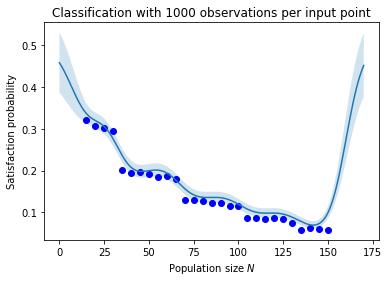

In [54]:
# function to compute probit values
def standardNormalCDF(x):
    return 1/2 + 1/2 * erf(x * (1/np.sqrt(2)))


cached_denominator = (1 / np.sqrt(1 + vfs)).reshape(-1,1)


# get probabilities with probit function
probabilities = standardNormalCDF(fs * cached_denominator)


# compute confidence bounds
lowerbound = standardNormalCDF((fs - 1.96 * np.sqrt(vfs).reshape(-1,1)) *
                              cached_denominator)
upperbound = standardNormalCDF((fs + 1.96 * np.sqrt(vfs).reshape(-1,1)) *
                              cached_denominator)

# plot data
plt.plot(testpoints, probabilities, lw=1.5, ls='-')
plt.fill_between(testpoints.ravel(), lowerbound.ravel(), upperbound.ravel(), alpha=0.2)
plt.scatter(paramValueSet, paramValueOutputs, marker='o', c='blue')
plt.title(f'Classification with {scale} observations per input point')
plt.xlabel('Population size $N$')
plt.ylabel('Satisfaction probability')
#plt.yticks([0, 1])
plt.show()